# Homework 3 - von Neumann

Let's gather up everything we need and create some plots to start:

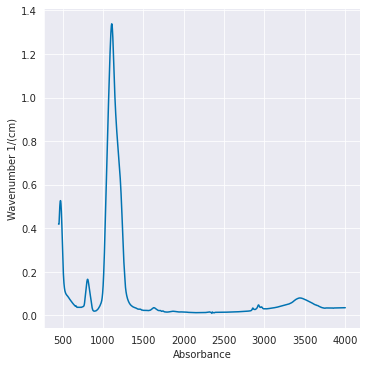

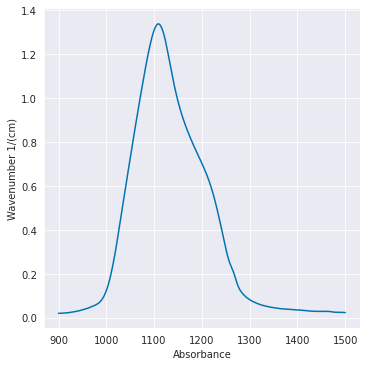

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = (pd.read_csv('data/Silica.csv', header=None)
    .rename(columns={0:"Wavenumber 1/(cm)", 1:"Absorbance"})
    .set_index("Wavenumber 1/(cm)"))

df = df.iloc[::-1]  # this is to flip the dataframe, so we have it ordered from low to high wavenumbers.

sns.set_style("darkgrid")
sns.set_palette("colorblind")  # This time we are thoughtful :)

plot = sns.relplot(data=df, kind="line", legend=False)
plot.set(xlabel='Absorbance', ylabel='Wavenumber 1/(cm)')
plt.show()

dfr = df[900:1500]
plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Absorbance', ylabel='Wavenumber 1/(cm)')
plt.savefig(f'sns.png', bbox_inches='tight')
plt.show()


#### Let's first try to identify the peak points on the graph to decide where to put all the Gaussians. After adding a few more gridlines, just eyeballing it, the first three look clear to get an idea, so we can pinpoint them exactly later:

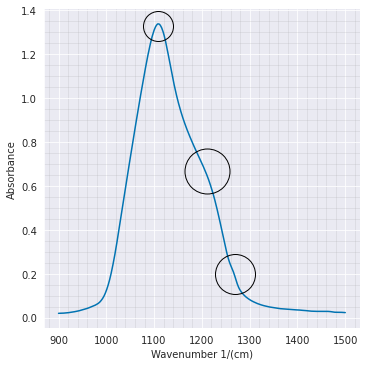

In [2]:
sns.set_style()
plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot([1109],[1.33],'o', ms=30, mec='k', mfc='none')
plt.plot([1210],[0.67],'o', ms=45, mec='k', mfc='none')
plt.plot([1270],[0.20],'o', ms=40, mec='k', mfc='none')
plt.show()

#### Let's take a closer look at the 1350 - 1500 range to pick the other two:

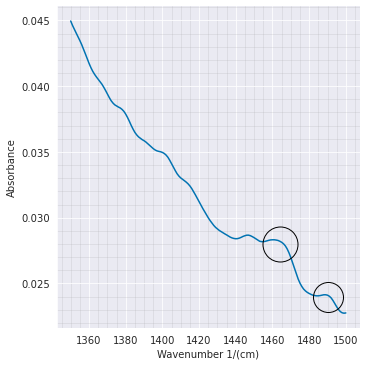

In [3]:
plot2 = sns.relplot(data=dfr[1350:1500], kind='line', legend=False)
plot2.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot([1464],[0.028],'o', ms=35, mec='k', mfc='none')
plt.plot([1490],[0.024],'o', ms=30, mec='k', mfc='none')
plt.show()

#### There's a bunch we can choose from, but the more significant ones seem to be around wavenumbers 1465 and 1490.
 We have a few good starting points now, we can begin analyzing!
 
 _A note from the future: we don't end up actually using these points, but we've decided to keep them here to make the thought process more live 8)_

# Using 3 Gaussians:

In [4]:
def Gauss(x,A,mu,sigma):
    y = A*np.exp(-(x-mu)**2/(2*sigma**2))
    return y
dfr

,Absorbance
Wavenumber 1/(cm),
900.0,0.01941
901.0,0.01946
902.0,0.01951
903.0,0.01954
904.0,0.01957
...,...
1496.0,0.02302
1497.0,0.02286
1498.0,0.02277


Let's first try to catch that peak point to start, right onto the ymax point:

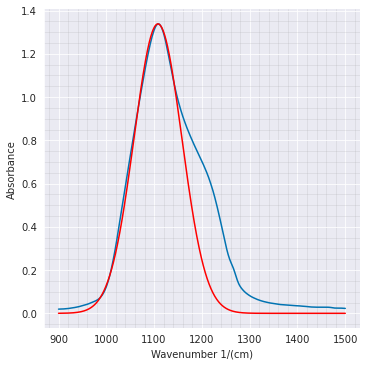

In [5]:
ymax = dfr.max().values[0]
x_ymax = dfr.idxmax().values[0]
x = dfr.index.values

gauss1 = Gauss(x, ymax, x_ymax, 50)  # The 50 sigma value there fit great right away, lucky guess 8)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.show()

For the second, we can try zooming into the 1200-1250 range:

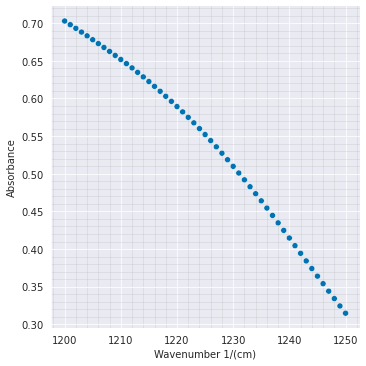

In [6]:
plot3 = sns.relplot(data=dfr[1200:1250], legend=False)
plot3.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

Somewhere around 1220 looks like the right point, but to find where the optimal point is for sure, it would have been nice to check the second derivative of this function, we can reason that the optimal point would be the point with the minimum second derivative, as that will be the point in which the function would have its largest "concave downward", so we can try hacking this numerically, creating our own fake derivative by checking the slopes at all points:

In [7]:
def fake_derivative(dataframe, x_from, x_to):
    
    # Here x_from:x_to will be a range in df.index.values, like 1200:1250 in our case,
    # we will have the function take all "derivatives" for all of these points.
    
    fake_derivatives = np.empty(0)
    x_values = dataframe[x_from:x_to].index.values
    y_values = dataframe[x_from:x_to].values
    
    # We are going to define delta x as dx = x(i+1) - x(i), so we need to write the for loop
    # with the indexes, rather than the objects:
    # (the delta x values will all be -1 in this case of course, but we want to code generally 8))
    
    for i in range(len(x_values)-1):  # -1 is needed because we call on the i+1 index
        x1, x2 = x_values[i], x_values[i+1]
        y1, y2 = y_values[i], y_values[i+1]
        dx = x2 - x1
        dy = y2 - y1
        fake_derivative = dy/dx
        fake_derivatives = np.append(fake_derivatives, fake_derivative)
        
    x_values_dropone = x_values[:-1]  # We need to drop the last value, otherwise we have
        # one more index than we have derivatives, and Pandas doesn't like that.
        
    # Now we can put these together in a DataFrame:
    fake_derivatives_dataframe = pd.DataFrame({"x":x_values_dropone, 
                            "Slopes":fake_derivatives}).set_index("x")
    
    return fake_derivatives_dataframe

In [8]:
fake_derivative(dfr, 1200, 1250).head(10)

,Slopes
x,
1200.0,-0.00487
1201.0,-0.00488
1202.0,-0.00492
1203.0,-0.00505
1204.0,-0.00515
1205.0,-0.00513
1206.0,-0.00513
1207.0,-0.00525
1208.0,-0.00535


Well that has worked swimmingly, I think, but to get the "second derivatives" we need to run it again on this dataframe:

In [9]:
d_dfr = fake_derivative(dfr, 1200, 1250)
dd_dfr = fake_derivative(d_dfr, 1200, 1249)  # again we drop one value here to line them up, which could be
# a potential problem for the function, but is fine for our case, as we care more about the 1215-1230 range.
dd_dfr.head(10)

,Slopes
x,
1200.0,-1.000000e-05
1201.0,-4.000000e-05
1202.0,-1.300000e-04
1203.0,-1.000000e-04
1204.0,2.000000e-05
1205.0,-1.110223e-16
1206.0,-1.200000e-04
1207.0,-1.000000e-04
1208.0,-5.000000e-05


In [10]:
dd_dfr.idxmin()  # we are looking at negative derivatives here, so we will take the min value

Slopes    1222.0
dtype: float64

Well there it is, the point we need seems to be 1222, so our eyeball guess was actually pretty close, let's see if it was worth all the effort!

When we put our second gaussian here, we want the sum of the two at that peak point to be equal to the actual values we have at 1222, so let's call the old gauss1 we have defined, and see the difference it has to the point 1222, that will be the magnitude of our second gaussian.

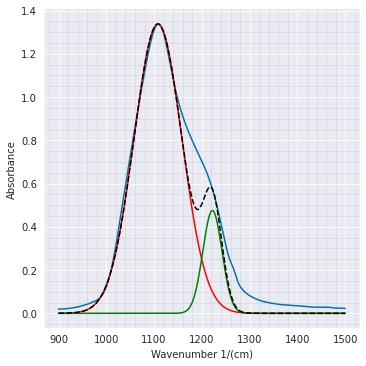

In [161]:
g1_1222 = gauss1[np.where(x == 1222)]
dfr_1222 = dfr.loc[1222].values[0]
A2 = dfr_1222 - g1_1222

gauss2 = Gauss(x, A2, 1222, 20)  # time to plot!

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss1 + gauss2, "--k")
plt.show()

We've hit our spot, as expected, but we need to make that 20 sigma a bit larger to get the sides to fit, however if we only adjust the sigma of this one, we are limited by the previous peak we got, as this second Gaussian gets spread out, it starts to affect the territory of the first one, so the best way to get a good fit here would be to also adjust the max value for the first Gaussian. To do this right, we want to know how much the second Gaussian is affecting the ymax point, so we can check that value as we adjust the sigma, and automatically adjust the magnitude of the first one.

I'm going to call this value `interference2`, and it is just the value of gauss2 at x_ymax:

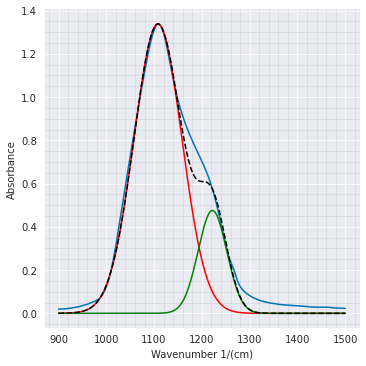

In [12]:
ymax = dfr.max().values[0]
x_ymax = dfr.idxmax().values[0]

gauss2 = Gauss(x, A2, 1222, 30)
interference2 = gauss2[np.where(x == x_ymax)]

gauss1 = Gauss(x, ymax - interference2, x_ymax, 50)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss1 + gauss2, "--k")
plt.show()

So this picture now screams "please put the third Gaussian in the middle of the two to fill the gap", looks like that area matters a lot more than the small peaks we have found by zooming in, because if we want to get the peak points exactly right, there's nothing much more we can do for the rest with these two Gaussians, so let's use the third one as a filler.

We can start by determining the largest difference between the made up function that's the sum of our two Gaussians, and the actual data. We can easily find all of these differences in a for loop, between values 1160 and 1200:

In [13]:
g1g2 = gauss1 + gauss2

g1g2_errors = np.empty(0)

for i in range(1160,1200):
    
    gauss_value = g1g2[np.where(x == i)][0]
    real_value = dfr.loc[i].values[0]
    error = real_value - gauss_value
    g1g2_errors = np.append(g1g2_errors, error)

g1g2_max_error = g1g2_errors.max()
ind = np.where(g1g2_errors == g1g2_errors.max())[0][0] # this is the index that has the max error 0-39
actual_index = range(1160,1200)[ind] # this is the index in our range.
print(f"Maximum error is {g1g2_max_error} at wavenumber {actual_index}")

Maximum error is 0.1450056127487951 at wavenumber 1181


The wavenumber 1185 has the maximum value at this point, so we can put our third Gaussian there to plug the hole, and we can pick its amplitude to be equal to `g1g2_max_error`. We can also do the same calculation with interference as last time, I'm not going to make it large enough to affect the first peak, so we can just focus on the 2nd one:

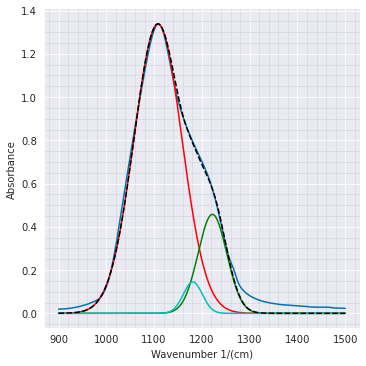

In [14]:
A3 = g1g2_max_error
gauss3 = Gauss(x, A3, actual_index, 20)

interference3 = gauss3[np.where(x == 1222)]
gauss2 = gauss2 = Gauss(x, A2 - interference3, 1222, 30)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss3, "c")
plt.plot(x, gauss1 + gauss2 + gauss3, "--k")
plt.show()

Looks great, we can be proud of that 8)! Let's write down a quick error function to see how we actually did:

In [15]:
def gauss_vs_reals(dataframe, gaussians_df, x_from, x_to):
    real_values = dataframe[x_from:x_to].values
    gauss_values = gaussians_df[x_from:x_to].values
    total_error = 0
    total_error_percent = 0
    
    for i in range(x_to - x_from + 1):
        
        error = real_values[i][0] - gauss_values[i][0]
        total_error += error
    
    total_error_percent = total_error / np.sum(real_values) * 100
    return (total_error, total_error_percent)

In [16]:
g1g2g3 = gauss1 + gauss2 + gauss3
indexes_123 = np.arange(900,1501, dtype="float") # apparently, the df[x1:x2] call only works for float indexes?
gauss123_df = pd.DataFrame({"x":indexes_123, "Values":g1g2g3}).set_index("x")

errors123 = gauss_vs_reals(dfr, gauss123_df, 900, 1500)
print(f"The total error is {errors123[1]} %")

The total error is 5.377666549144154 %


5.4% is not bad, but is also not really a very fair way to analyze the error, as the parts we are focusing are in the range 980-1300 for this part, let's also run it for that range:

In [17]:
errors123_2 = gauss_vs_reals(dfr, gauss123_df, 980, 1300)
print(f"The total error is {errors123_2[1]} %")

The total error is 1.2317810847846749 %


Much better!

### Coefficients of Determination Calculator:

In [57]:
def r_squared(dataframe, guess_function):
    
    df_yvalues = dataframe.values
    df_ymean = np.mean(df_yvalues)
    guess_yvalues = guess_function
    
    St_sum = 0
    Sr_sum = 0
    for i in range(len(df_yvalues)):
        
        resmean = (df_yvalues[i][0] - df_ymean)**2
        St_sum += resmean
        resdf_guess = (df_yvalues[i][0] - guess_yvalues[i])**2
        Sr_sum += resdf_guess
        
    return (St_sum - Sr_sum)/St_sum
    

In [64]:
coeff_123 = r_squared(dfr, g1g2g3)
print(f"The coefficient of determination for the 3 Gaussian fit: {coeff_123}")

The coefficient of determination for the 3 Gaussian fit: 0.9943713831469964


## Using 4 Gaussians:

Strategizing from here, we can go a couple different ways; we can nitpick on the smaller peaks we have found by zooming in, we can add a largely spread Gaussian with a small amplitude on the right side to close the gap, or we could focus on the slight deviation we have from the left side of the large curve, as we have a lot of control over the right side of the large curve (since we have our two smaller Gaussians there) we could make the first red Gaussian thinner and fill up the left side. But considering the entire range it does seem like the best choice for a fourth Gaussian will be to focus on the right side of the third Gaussian, the 1280+ range, we have a lot of deviation there.

We can start the same way we did for the third Gaussian, by finding point with the largest error and jamming the Gaussian in there, so copy-pasting the code:

In [84]:
g1g2g3_errors = np.empty(0)

for i in range(1280,1500):
    
    gauss_value = g1g2g3[np.where(x == i)][0]
    real_value = dfr.loc[i].values[0]
    error = real_value - gauss_value
    g1g2g3_errors = np.append(g1g2g3_errors, error)
    
g1g2g3_max_error = g1g2g3_errors.max()
ind123 = np.where(g1g2g3_errors == g1g2g3_errors.max())[0][0]
actual_index123 = range(1280,1500)[ind123]
print(f"Maximum error is {g1g2g3_max_error} at wavenumber {actual_index123}")

Maximum error is 0.06524466929726622 at wavenumber 1300


We want to gather up all our Gaussian definitions and `interference` terms here so we can tweak, and we want to define an `interference4` to tweak `gauss3` just in case the new one gets spread enough to affect it:

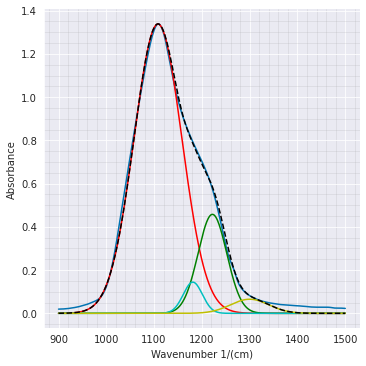

In [97]:
A4 = g1g2g3_max_error
gauss4 = Gauss(x, A4, actual_index123, 40)
interference4 = gauss4[np.where(x == actual_index)]

gauss3 = Gauss(x, A3 - interference4, actual_index, 20)
interference3 = gauss3[np.where(x == 1222)]
gauss2 = gauss2 = Gauss(x, A2 - interference3, 1222, 30)
interference2 = gauss2[np.where(x == x_ymax)]
gauss1 = Gauss(x, ymax - interference2, x_ymax, 50)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss3, "c")
plt.plot(x, gauss4, "y")
plt.plot(x, gauss1 + gauss2 + gauss3 + gauss4, "--k")

plt.show()

Seems pretty good after a few tweaks, let's see if there's any improvement on the coefficient of determination:

In [98]:
g1g2g3g4 = gauss1 + gauss2 + gauss3 + gauss4
coeff_1234 = r_squared(dfr, g1g2g3g4)
print(f"The coefficient of determination for the 4 Gaussian fit: {coeff_1234}")
print(f"\nDifference with the 3 Gaussian fit: {coeff_1234 - coeff_123}")

The coefficient of determination for the 4 Gaussian fit: 0.996936639661813

Difference with the 3 Gaussian fit: 0.0025652565148166495


Getting closer to 1 from 0.99... in this calculation gives us diminishing returns, so it's difficult to see how much we've improved, how about the errors?

In [99]:
indexes_1234 = np.arange(900,1501, dtype="float")
gauss1234_df = pd.DataFrame({"x":indexes_1234, "Values":g1g2g3g4}).set_index("x")

errors1234 = gauss_vs_reals(dfr, gauss1234_df, 900, 1500)
print(f"% error for the 3 Gaussian fit: {errors123[1]}")
print(f"\n% error for the 4 Gaussian fit: {errors1234[1]}")

% error for the 3 Gaussian fit: 5.377666549144154

% error for the 4 Gaussian fit: 2.4354134229719144


Those numbers are more satisfying 8)

# Using 5 Gaussians

May be a bit repetitive but looking at our final plot it seems like the best we can do with this one is to again stick it onto the right and make it as spread out as possible:

In [90]:
g1g2g3g4_errors = np.empty(0)

for i in range(1280,1500):
    
    gauss_value = g1g2g3g4[np.where(x == i)][0]
    real_value = dfr.loc[i].values[0]
    error = real_value - gauss_value
    g1g2g3g4_errors = np.append(g1g2g3g4_errors, error)
    
g1g2g3g4_max_error = g1g2g3g4_errors.max()
ind1234 = np.where(g1g2g3g4_errors == g1g2g3g4_errors.max())[0][0]
actual_index1234 = range(1280,1500)[ind1234]
print(f"Maximum error is {g1g2g3g4_max_error} at wavenumber {actual_index1234}")

Maximum error is 0.03223330137811331 at wavenumber 1402


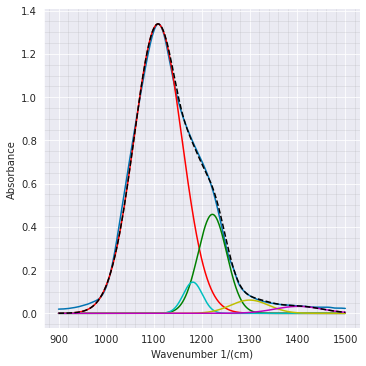

In [100]:
A5 = g1g2g3g4_max_error
gauss5 = Gauss(x, A5, actual_index1234,50)
interference5 = gauss5[np.where(x == actual_index123)]

A4 = g1g2g3_max_error
gauss4 = Gauss(x, A4-interference5, actual_index123, 40)
interference4 = gauss4[np.where(x == actual_index)]

gauss3 = Gauss(x, A3-interference4, actual_index, 20)
interference3 = gauss3[np.where(x == 1222)]
gauss2 = gauss2 = Gauss(x, A2 - interference3, 1222, 30)
interference2 = gauss2[np.where(x == x_ymax)]
gauss1 = Gauss(x, ymax - interference2, x_ymax, 50)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss3, "c")
plt.plot(x, gauss4, "y")
plt.plot(x, gauss5, "m")
plt.plot(x, gauss1 + gauss2 + gauss3 + gauss4 + gauss5, "--k")

plt.show()

#### Let's also see the final product on its own:

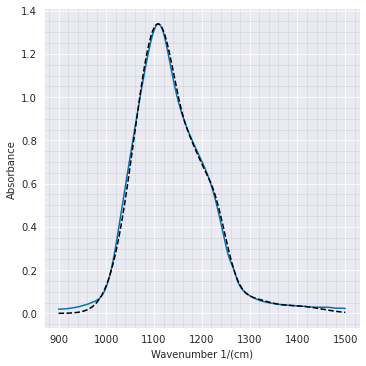

In [105]:
plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1 + gauss2 + gauss3 + gauss4 + gauss5, "--k")

plt.show()

In [103]:
g1g2g3g4g5 = gauss1 + gauss2 + gauss3 + gauss4 + gauss5
coeff_12345 = r_squared(dfr, g1g2g3g4g5)
print(f"The coefficient of determination for the 5 Gaussian fit: {coeff_12345}")
print(f"\nDifference with the 4 Gaussian fit: {coeff_12345 - coeff_1234}")

The coefficient of determination for the 5 Gaussian fit: 0.9979052474762328

Difference with the 4 Gaussian fit: 0.0009686078144197641


In [102]:
indexes_12345 = np.arange(900,1501, dtype="float")
gauss12345_df = pd.DataFrame({"x":indexes_12345, "Values":g1g2g3g4g5}).set_index("x")

errors12345 = gauss_vs_reals(dfr, gauss12345_df, 900, 1500)
print(f"% error for the 4 Gaussian fit: {errors1234[1]}")
print(f"\n% error for the 5 Gaussian fit: {errors12345[1]}")

% error for the 4 Gaussian fit: 2.4354134229719144

% error for the 5 Gaussian fit: 0.8359428733465349


That drops us bellow %1 error, definitely satisfying! 8)

# Using 3 Lorentzians

Let's start by defining the Lorentzian, along with an amplitude multiplier:

In [20]:
def Lorentzian(x,A,x0,Gamma):
    Lx = (A)*(Gamma)**2/((x-x0)**2+(Gamma)**2)
    return Lx

$$
    \frac{A \,\Gamma^2}{(x-x_0)^2+\Gamma^2}
$$

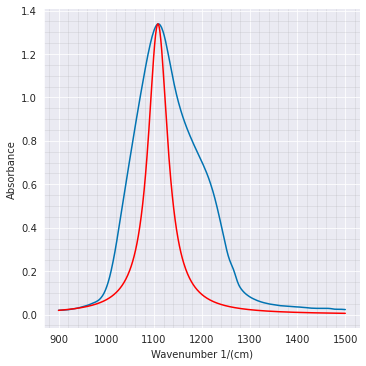

In [21]:
lorentzian1 = Lorentzian(x, ymax, 1108, 25)

plotL = sns.relplot(data=dfr, kind="line", legend=False)
plt.plot(x, lorentzian1, "r")
plotL.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

With the Lorentzian, the shape doesn't work for this method as well as it did with Gaussians, when we try to fit the peak point perfectly, since the peak is more "spiked", the sides don't get filled up, so it doesn't seem like a good strategy to start with the peaks, we should instead put all our Lorentzians together first, focus on filling up the whole curve and have their sums reach the peaks as we go. 

The simple plan right now is to add the two Lorentzians first to sooort of resemble the peaks, then add a third, more mild and spread one in the middle to shoot them up to line up with the peaks. For this to work, we are going to need these two equations to be satisfied:

$$
L_1(x_{peak1}) + L_2(x_{peak1}) + L_3(x_{peak1}) = dfr(x_{peak1})
$$ 

$$
L_1(x_{peak2}) + L_2(x_{peak2}) + L_3(x_{peak2}) = dfr(x_{peak2})
$$

Since the first Lorentzian is lined up to the first peak, for the first equation to always be satisfied, we can again subtract the interferences of the second and third Lorentzians from the first ones amplitude. For the second one we can subtract the thirds interference, and then adjust the width of all of the Lorentzians, and adjust whatever we want on the third one, _then_ redifine the second one again depending on the new interference of the first one, which _seems_ to work...

For the amplitudes and x0 values we start by using our results from the 3 Gaussians fit:

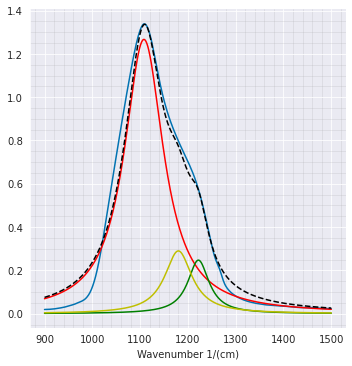

In [190]:
A3 = g1g2_max_error  # from the 3 Gauss fit
A2 = dfr_1222 - g1_1222  # also from the 3 Gauss fit

lorentzian3 = Lorentzian(x, A3*2, 1180, 35)
# interferences of the 3rd lorentzian to the first and second:
interference31 = lorentzian3[np.where(x == 1108)]
interference32 = lorentzian3[np.where(x == 1222)]

lorentzian2 = Lorentzian(x, A2-interference32, 1222, 25)
# interference of the 2nd to the first
interference21 = lorentzian2[np.where(x == 1108)]

lorentzian1 = Lorentzian(x, ymax-interference31-interference21, 1108, 50)
# interference of the first to the 2nd
interference12 = lorentzian1[np.where(x == 1222)]

lorentzian2 = Lorentzian(x, A2*1.2-interference32-interference12, 1222, 27)

plotL = sns.relplot(data=dfr, kind="line", legend=False)
plt.plot(x, lorentzian1, "r")
plt.plot(x, lorentzian2, "g")
plt.plot(x, lorentzian3, "y")
plt.plot(x, lorentzian1 + lorentzian2 + lorentzian3, "k--")
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

Unfortunately we weren't able to do much better than this, got at least decently close on the inside of the curve, but the left side especially shot off the roof. 8(

In [191]:
l1l2l3 = lorentzian1 + lorentzian2 + lorentzian3
l1l2l3_coeff = r_squared(dfr, l1l2l3)
print(f"The coefficient of determination for the 3 Lorentzian fit: {l1l2l3_coeff}")

The coefficient of determination for the 3 Lorentzian fit: 0.9778050931774157


At least it is above the 0.975 mark ^^

# 2 Gaussians and 2 Lorentzians

Now we have the best of both worlds, we can use the width of the Gaussians to reach the peak points of the graph while still getting a good fill all around, and we can use the wide spread of the Lorentzians to fill up all the non-peaking areas under the curve. Our previous 2 Gaussian fit will be a good place to start, as it already covers the two larger peaks:

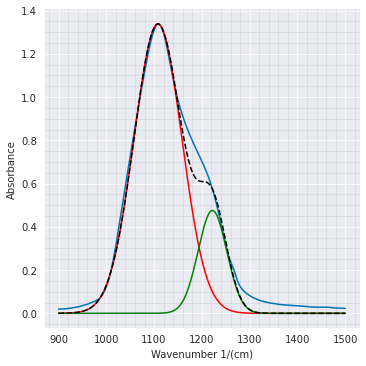

In [106]:
ymax = dfr.max().values[0]
x_ymax = dfr.idxmax().values[0]

gauss2 = Gauss(x, A2, 1222, 30)
interference2 = gauss2[np.where(x == x_ymax)]

gauss1 = Gauss(x, ymax - interference2, x_ymax, 50)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, gauss1 + gauss2, "--k")
plt.show()

Now let's add Lorentzian number one to the maximum error point (again from the 3 Gaussian fit), and adjust the amplitudes of the two Gaussians according to its interference:

Note after a bit of trial: it seems like it is a better option to add the first Lorentzian to a little bit towards the right of the maximum error point, this way it doesn't interfere as much with the right side of the first Gaussian (since that is not very easy to control, any change to the width of the red Gaussian leads to the left side of the curve being underfilled), and also since there is more error on the right of the max error point than the left, so more area to cover there. So we've moved it to the right, to wavenumber 1190 instead of 1181, and gave it an amplitude of A3*1.15 to match up.

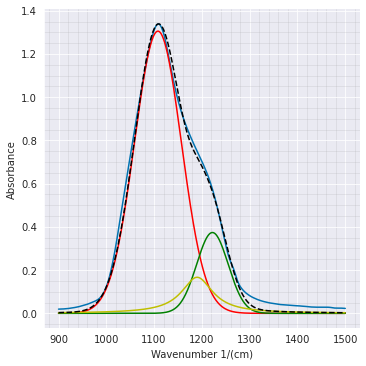

In [202]:
lorentzian_1 = Lorentzian(x, A3*1.15, 1190, 40)
# interference of the first Lorentzian to the first and second Gaussians:
interferenceL11 = lorentzian_1[np.where(x == x_ymax)]
interferenceL12 = lorentzian_1[np.where(x == 1222)]

# total interference on the second Gaussian:
interference2_total = interferenceL12
gauss2 = Gauss(x, A2 - interference2_total, 1222, 33)
# interference of the second Gaussian to the first:
interference2 = gauss2[np.where(x == x_ymax)]

# total interference on the first Gaussian:
interference1_total = interference2 + interferenceL11
gauss1 = Gauss(x, ymax - interference1_total, x_ymax, 49)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, lorentzian_1, "y")
plt.plot(x, gauss1 + gauss2 + lorentzian_1, "--k")
plt.show()

That looks pretty good, now we can fill in the empty areas on the right side of the curve by using a pressed down Lorentzian, we don't want to put this one to the max error point, but instead want to place it somewhere in the middle of the right side, at around wavenumber 1400, so it has the largest overall effect, covers as much of the gap as possible. To get started with the amplitude, we can use the A5 value we've used for our 5th Gaussian from earlier, which played a similar role to this, and adjust it from there:

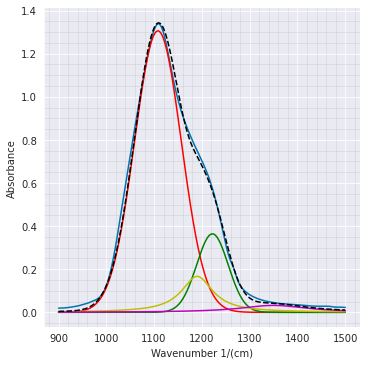

In [221]:
lorentzian_2 = Lorentzian(x, A5, 1350, 85)
# interference of the second Lorentzian to the second Gaussian, this is the only one worth calculating:
interferenceL22 = lorentzian_2[np.where(x == 1222)]

lorentzian_1 = Lorentzian(x, A3*1.15, 1190, 40)
# interference of the first Lorentzian to the first and second Gaussians:
interferenceL11 = lorentzian_1[np.where(x == x_ymax)]
interferenceL12 = lorentzian_1[np.where(x == 1222)]

# total interference on the second Gaussian:
interference2_total = interferenceL12 + interferenceL22
gauss2 = Gauss(x, A2 - interference2_total, 1222, 33)
# interference of the second Gaussian to the first:
interference2 = gauss2[np.where(x == x_ymax)]

# total interference on the first Gaussian:
interference1_total = interference2 + interferenceL11
gauss1 = Gauss(x, ymax - interference1_total, x_ymax, 49)

plot = sns.relplot(data=dfr, kind="line", legend=False)
plot.set(xlabel='Wavenumber 1/(cm)', ylabel='Absorbance')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.plot(x, gauss1, "r")
plt.plot(x, gauss2, "g")
plt.plot(x, lorentzian_1, "y")
plt.plot(x, lorentzian_2, "m")
plt.plot(x, gauss1 + gauss2 + lorentzian_1 + lorentzian_2, "--k")
plt.show()

In [222]:
g1g2l1l2 = gauss1 + gauss2 + lorentzian_1 + lorentzian_2
g1g2l1l2_coeff = r_squared(dfr, g1g2l1l2)
print(f"The coefficient of determination for the 2 Gaussian + 2 Lorentzian fit: {g1g2l1l2_coeff}")

The coefficient of determination for the 2 Gaussian + 2 Lorentzian fit: 0.9966883278214513


It seems like we have excelled the most with the Gaussians, this is because it feels a lot more difficult to control the width of a Lorentzian, especially when trying to reach some high, steep peaks, we just weren't very comfortable working with them, at least for this dataset. For a more pressed down set of data, Lorentzians would probably be much easier to use and perhaps would be a better fit than the Gaussians. We still got a decent result by mixing up both of the functions, pretty close to our result with 5 Gaussians, that means we have saved one function, and got just about the same accuracy, which should make the mix a better option! 

The "interference" method we've used came in especially handy, instead of endlessly tweaking every single function and tweaking each one again after our tweaks on one ruined everything we've done so far, we simply were able to tweak one and the others would auto-adjust, relatively accurately. However we couldn't come up with a similar mechanism to also auto-adjust the widths of the functions this way, it only worked for the peaks (which again made Lorentzians more difficult to work with).

#### It was overall a very productive exercise, and now we feel like no curve could escape our fitting powers! 8)

## References:

There has been more playing around than research for this homework, so our references are mostly just the definitions of the functions, and a few examples:

Fiz353 - 07 Regression Lecture Notes

http://www.emilygraceripka.com/blog/16

https://en.wikipedia.org/wiki/Spectral_line_shape#Lorentzian

https://mathworld.wolfram.com/LorentzianFunction.html

https://en.wikipedia.org/wiki/Cauchy_distribution
